In [1]:
#This notebook aims to graph actual stock price movement
#... hopefully we can get away from lognormal volatility
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
days = 5
res = (60*5)/2 #60/2 events per hour.. 5 hours per trading day
T = int(days * res)
sims = int(1e7)
K_call = 15.40
K_put = 12.46
stock = yf.Ticker("OCGN")
asset_price = 7.11
price_history = stock.history(period="59d", interval="2m")

In [2]:
print(price_history)

                             Open   High     Low   Close   Volume  Dividends  \
Datetime                                                                       
2021-02-26 09:30:00-05:00  8.0500  8.140  7.9000  7.9000  1504551          0   
2021-02-26 09:32:00-05:00  7.9500  8.412  7.9300  8.3301   344095          0   
2021-02-26 09:34:00-05:00  8.3300  8.360  8.2100  8.3201   167328          0   
2021-02-26 09:36:00-05:00  8.3200  8.450  8.2600  8.4350   208994          0   
2021-02-26 09:38:00-05:00  8.4389  8.500  8.3500  8.4900   252073          0   
...                           ...    ...     ...     ...      ...        ...   
2021-04-09 15:50:00-04:00  6.9791  7.000  6.9703  7.0000    95265          0   
2021-04-09 15:52:00-04:00  6.9950  7.010  6.9700  6.9800   236672          0   
2021-04-09 15:54:00-04:00  6.9752  6.990  6.9650  6.9850    88625          0   
2021-04-09 15:56:00-04:00  6.9800  7.000  6.9800  6.9950   156176          0   
2021-04-09 15:58:00-04:00  6.9900  7.000

In [3]:
close_history = price_history["Close"]
daily_return = []
for i in range(len(close_history) - 1):
    d_return = (close_history[i + 1] - close_history[i])/close_history[i]
    daily_return.append(d_return)
    

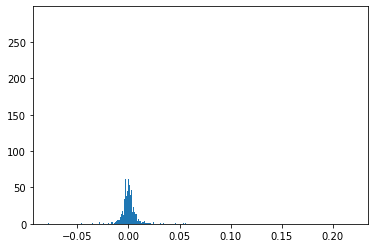

In [4]:
resolution = int(len(daily_return)/2)
hist = plt.hist(daily_return, bins=resolution)
plt.show()

def kelly2(hist, res=100, f_max=1.0):
    pl = []
    for i in range(len(list(hist[1])) - 1):
        price_ratio = (hist[1][i + 1] + hist[1][i])/2
        pl.append(price_ratio)
    
    density = hist[0]/np.sum(hist[0])
    
    Z = []
    F = []
    for k in range(res):
        f = ((k + 1)/(res))*f_max
        F.append(f)
        z = density * np.log(1 + f*np.array(pl))
        Z.append(np.sum(z))
    
    indices = np.where(np.abs(Z) <= 0.0000001)
    optimum = np.array(F)[indices]
    
    print("Kelly: ", optimum)
    print("Mean Kelly: ", np.mean(optimum))
    return F, Z

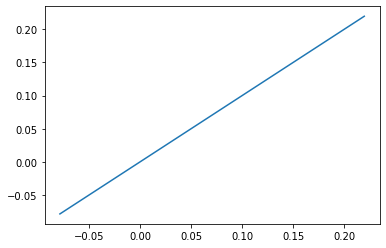

In [5]:
pl = []
for i in range(len(list(hist[1])) - 1):
    price_ratio = (hist[1][i + 1] + hist[1][i])/2
    pl.append(price_ratio)

plt.plot(pl, pl)
plt.show()

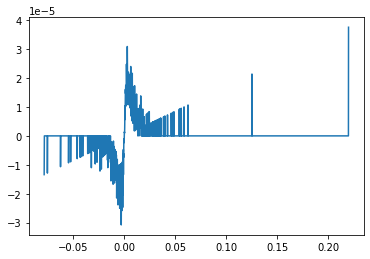

In [6]:
density = hist[0]/np.sum(hist[0])

payout_func = density*np.array(pl)
plt.plot(pl, payout_func)
plt.show()

Kelly:  [0.003 0.006 0.009 0.012 0.015 0.018 0.174 0.177 0.18  0.183 0.186 0.189
 0.192 0.195 0.198 0.201 0.204 0.207]
Mean Kelly:  0.13049999999999998


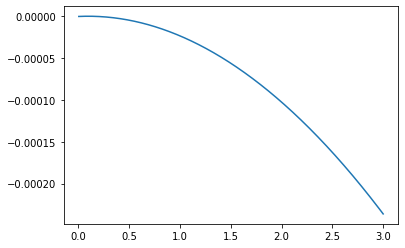

In [7]:
#Calculate Kelly
F, Z = kelly2(hist, f_max=3, res=1000)
plt.plot(F, Z)
plt.show()

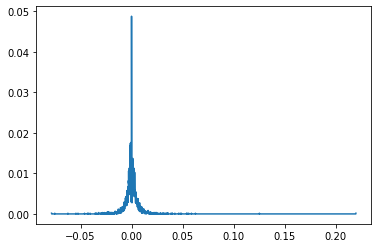

In [8]:
plt.plot(pl, density)
plt.show()

In [9]:
def simulate_stonk(s0, fn, pl, days=30, num=100):
    s = np.full((days, num), s0)
    random_movements = np.random.choice(pl,p=fn, size=(days-1, num))
    for t in range(days - 1):
        rm = random_movements[t]
        s[t + 1] = rm*s[t] + s[t]
        
    return s

In [10]:
sims=10000
s_t = simulate_stonk(asset_price, density, pl, days=int(T), num=sims)
print(s_t.shape)

(750, 10000)


In [11]:
def plot_MC(mat, days=30, num=100):
    for i in range(num):
        plt.plot(mat[:, i])
    plt.show()

def call_prob(s_t, K, expiry, num=100):
    area = expiry*num
    cond = np.where(s_t > K, 1, 0)
    sub_sum = np.sum(cond)
    return sub_sum/area

def simulated_payout(s_t, K, expiry, prem):
    cond = np.where(s_t[expiry-1] > K, (s_t[expiry-1]-K-prem), -prem)/prem
    return cond

def debit_spread_payout(s_t, K_1, K_2, expiry, prem_1, prem_2):
    p1 = np.where(s_t[expiry-1] > K_1, s_t[expiry-1]-K_1-prem_1, -prem_1)
    p2 = np.where(s_t[expiry-1] < K_2, prem_2, (K_2+prem_2) - s_t[expiry-1])
    cond = (p1 + p2)/(prem_1 - prem_2) #Turn it into return
    return cond
    

def put_prob(s_t, K, expiry, num=100):
    area = expiry*num
    cond = np.where(s_t < K, 1, 0)
    sub_sum = np.sum(cond)
    return sub_sum/area

In [12]:
#K_put = 
p = put_prob(s_t, K_put, T, num=sims)
print("Chance to pass strike: ", p)
print("Chance to profit off sell: ", 1-p)

Chance to pass strike:  0.9990536
Chance to profit off sell:  0.0009464000000000139


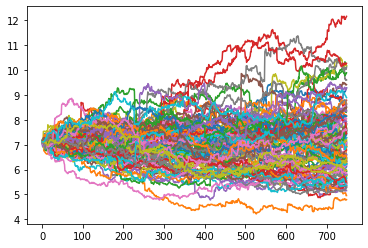

In [13]:
plot_MC(s_t, days=T, num=100)

In [14]:
#Find Call Price using simulation
def callprice(K_call, T, s_t, digits=10):
    num = 1e-5
    for i in range(digits):
        place = np.power(10.0, -i)
        if i == 0.0:
            for x in range(1000):
                cand = num + x
                payout = simulated_payout(s_t, K_call, T, cand)
                if np.mean(payout) == 0.0:
                    num = num + x
                    break
                    
                if np.mean(payout) < 0:
                    num = num + x - 1
                    break
        else:
            broken = False
            for x in range(9):
                cand = num + (x+1)*place
                payout = simulated_payout(s_t, K_call, T, cand)
                if np.mean(payout) < 0:
                    num = num + (x)*place
                    broken = True
                    break
            if not broken:
                num = num + 9*place
            
    return num

Strike + Breakeven:  10.36
Chance to pass strike:  0.010414533333333333
Buy Call Payout:  -0.8763026120439247
Chance to profit off sell:  0.9895854666666667


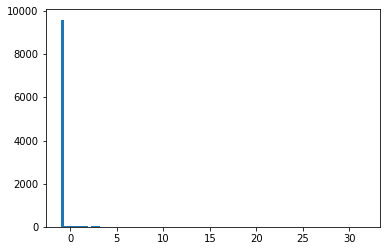

Kelly:  []
Mean Kelly:  nan


/Users/philipfelizarta/anaconda3/envs/trading/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/philipfelizarta/anaconda3/envs/trading/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
K_call = 10
prem = 0.36

p = call_prob(s_t, K_call + prem, T, num=sims)
payout = simulated_payout(s_t, K_call, T, prem)
print("Strike + Breakeven: ", K_call+prem)
print("Chance to pass strike: ", p)
print("Buy Call Payout: ", np.mean(payout))
print("Chance to profit off sell: ", 1-p)

call_hist = plt.hist(payout, bins=100)
plt.show()
F, Z = kelly2(call_hist, res=100, f_max=1.0)

In [47]:
Kcall = 7.5
#print(T)
print("Premium: ", callprice(Kcall, T, s_t, digits=10))

Premium:  0.4390051840000001


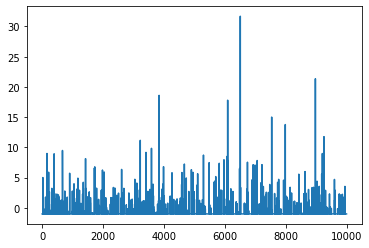

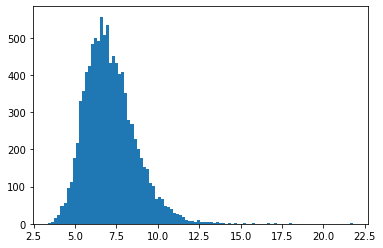

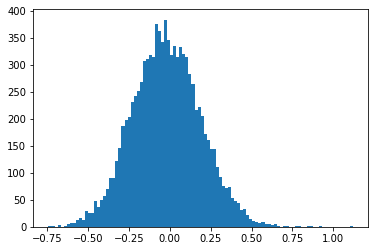

Implied Volatility:  0.20751050916058703
Yearly Volatility:  1.473178473630788
Mean:  -0.019997481647000957


In [21]:
plt.plot(payout)
plt.show()

#Plot the histogram of asset price at t=T
s_T = s_t[-1]
plt.hist(s_T, bins=100)
plt.show()

#Calculate implied volatility
ret = np.log(s_T/asset_price)
plt.hist(ret , bins=100)
plt.show()
vol = np.std(ret)
mu = np.mean(ret)
print("Implied Volatility: ", vol)
print("Yearly Volatility: ", (vol/np.sqrt(days))*np.sqrt(252))
print("Mean: ", mu)

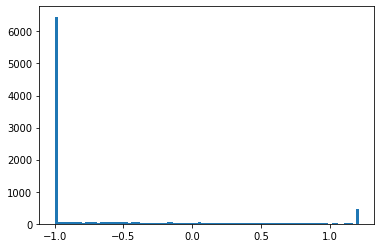

Kelly:  []
Mean Kelly:  nan


/Users/philipfelizarta/anaconda3/envs/trading/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/philipfelizarta/anaconda3/envs/trading/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
K_1 = 7.5
prem_1 = 7.8/2
K_2 = 10.0
prem_2 = 5.54/2

payout = debit_spread_payout(s_t, K_1, K_2, T, prem_1, prem_2)

call_hist = plt.hist(payout, bins=100)
plt.show()
F, Z = kelly2(call_hist, res=10000, f_max=1.0)

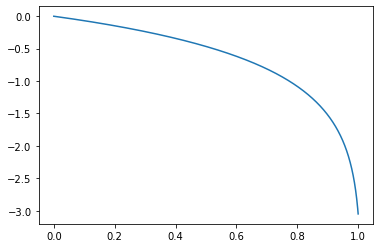

In [23]:
plt.plot(F, Z)
plt.show()

In [24]:
#April 6, 2021... model tells me debit spread on $OCGN bought on March 22, 2021 should have a position size of 
#0.5 percent. (its actually around 20) The model starting from today states much lower... I WILL HODL most of its gone
#aways... lets see who is right.

#Model believes my call 7.5 is worth 3 cents.. market prices it at 47 cents. again lets see whos right here... using 1mo 1d
#Surprisingly... when tuned on the 3mo 1d data.. the model prices the call at >1 dollar.
#At 1mo 2m... and an adjusted simulation for every 2m of the trading day.. model approximates a call price of 11.2 cents
#at K = 7.5. At K = 10.0, 0.49 cents. (currently at 22 cents)

Sigma:  0.20751050916058703
Mu:  1.9415047621681485
Algo Time:  0.4462599754333496
LogNormal Estimate Time:  0.011026144027709961


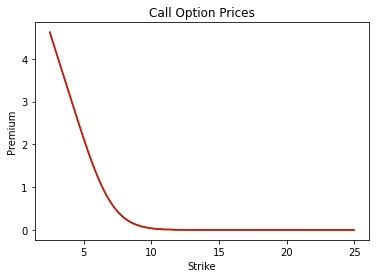

Error using LogNormal:  1.155959033853744e-05


In [44]:
from time import time

#Plot call prices
K_max = 25
K_min = 2.5
res = 1000
call_prices = []
call_prices2 = []
strikes = []

log_X = np.log(s_T)
vol = np.std(log_X)
mu = np.mean(log_X)
print("Sigma: ", vol)
print("Mu: ", mu)
t0 = time()
for i in range(res):
    K = (K_max-K_min)*(i/(res-1)) + K_min
    C = np.maximum(callprice(K, T, s_t, digits=3), 0.0)
    call_prices.append(C)
    strikes.append(K)
t1 = time()
for i in range(res):
    K = (K_max-K_min)*(i/(res-1)) + K_min
    c = 0.5 * (np.exp(mu + 0.5*np.square(vol)) * (1 - special.erf((np.log(K) - np.square(vol) - mu)/(np.sqrt(2)*vol)))
           - K * (1 - special.erf((np.log(K) - mu)/(np.sqrt(2) * vol))))
    call_prices2.append(c)
t2 = time()

print("Algo Time: ", t1-t0)
print("LogNormal Estimate Time: ", t2-t1)
error = np.mean(np.square(np.array(call_prices) - np.array(call_prices2)))
plt.plot(strikes, call_prices, c="green")
plt.plot(strikes, call_prices2, c="red")
plt.title("Call Option Prices")
plt.xlabel("Strike")
plt.ylabel("Premium")
plt.show()
print("Error using LogNormal: ", error)

<ipython-input-48-528ce77205f1>:16: RuntimeWarning: divide by zero encountered in log
  c = 0.5 * (np.exp(mu + 0.5*np.square(vol)) * (1 - special.erf((np.log(K) - np.square(vol) - mu)/(np.sqrt(2)*vol)))
<ipython-input-48-528ce77205f1>:17: RuntimeWarning: divide by zero encountered in log
  - K * (1 - special.erf((np.log(K) - mu)/(np.sqrt(2) * vol))))


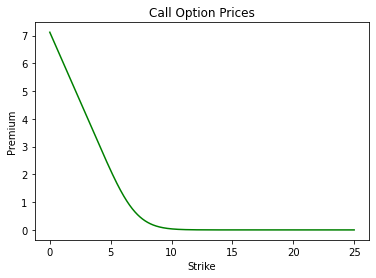

In [48]:
#Plot call prices using Estimator
from scipy import special

K_max = 25
K_min = 0.0
res = 1000
call_prices = []
strikes = []

log_X = np.log(s_T)
vol = np.std(log_X)
mu = np.mean(log_X)

for i in range(res):
    K = (K_max-K_min)*(i/(res-1)) + K_min
    c = 0.5 * (np.exp(mu + 0.5*np.square(vol)) * (1 - special.erf((np.log(K) - np.square(vol) - mu)/(np.sqrt(2)*vol)))
           - K * (1 - special.erf((np.log(K) - mu)/(np.sqrt(2) * vol))))
    call_prices.append(c)
    strikes.append(K)

plt.plot(strikes, call_prices, c="green")
plt.title("Call Option Prices")
plt.xlabel("Strike")
plt.ylabel("Premium")
plt.show()

